# Loading relevant Libraries

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from itertools import chain
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
import requests
import io
# NLTK setup
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Check if GPU is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading The datasets

In [2]:
# Download datasets using wget
!wget https://raw.githubusercontent.com/debajyotimaz/nlp_assignment/main/train_split.csv
!wget https://raw.githubusercontent.com/debajyotimaz/nlp_assignment/main/test_split.csv

# Load datasets from the downloaded files
train_data = pd.read_csv('train_split.csv')
test_data = pd.read_csv('test_split.csv')

--2024-10-16 15:24:11--  https://raw.githubusercontent.com/debajyotimaz/nlp_assignment/main/train_split.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144474 (141K) [text/plain]
Saving to: ‘train_split.csv’

train_split.csv     100%[===================>] 141.09K  --.-KB/s    in 0.02s   

2024-10-16 15:24:12 (6.29 MB/s) - ‘train_split.csv’ saved [144474/144474]

--2024-10-16 15:24:12--  https://raw.githubusercontent.com/debajyotimaz/nlp_assignment/main/test_split.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35259 (34K) 

# Datasets' Information

Missing values in training set:
 text        0
Joy         0
Fear        0
Anger       0
Sadness     0
Surprise    0
dtype: int64
Missing values in test set:
 text        0
Joy         0
Fear        0
Anger       0
Sadness     0
Surprise    0
dtype: int64

Value Counts in Training Set:
Joy:
 Joy
0    1222
1     378
Name: count, dtype: int64
Fear:
 Fear
1    931
0    669
Name: count, dtype: int64
Anger:
 Anger
0    1405
1     195
Name: count, dtype: int64
Sadness:
 Sadness
0    1097
1     503
Name: count, dtype: int64
Surprise:
 Surprise
0    1107
1     493
Name: count, dtype: int64


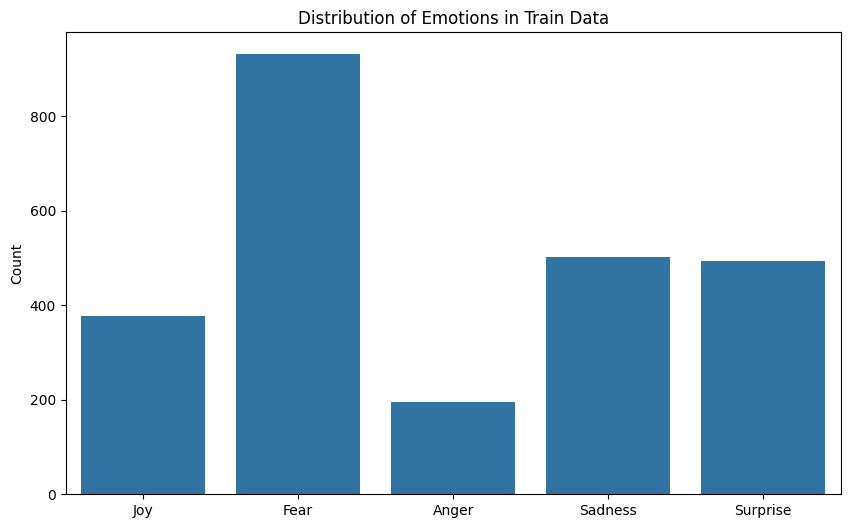

In [3]:
# Basic EDA: Check for missing values
print("Missing values in training set:\n", train_data.isnull().sum())
print("Missing values in test set:\n", test_data.isnull().sum())

# Emotions column names
emotions = ['Joy', 'Fear', 'Anger', 'Sadness', 'Surprise']

# Print value counts for each emotion in the training set
print("\nValue Counts in Training Set:")
for emotion in emotions:
    print(f"{emotion}:\n", train_data[emotion].value_counts())

# Plot distribution of emotions in the train set
plt.figure(figsize=(10, 6))
sns.barplot(x=emotions, y=train_data[emotions].sum().values)
plt.title('Distribution of Emotions in Train Data')
plt.ylabel('Count')
plt.show()

# Constaints

In [4]:
EMBEDDING_SIZE = 100
WINDOW_SIZE = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
NEG_SAMPLES = 5
BATCH_SIZE = 512
HIDDEN_UNITS = 64
BATCH_SIZE = 32

EMBEDDINGS_FILE = 'custom_word2vec_embeddings.npy'
WORD2IDX_FILE = 'word2idx_mapping.txt'


# Word2Vec Embedding

In [5]:
STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()

# Text cleaning function
def clean_text(text):
    words = re.sub(r'\W+', ' ', text.lower()).split()
    return [LEMMATIZER.lemmatize(w) for w in words if w not in STOP_WORDS]

# Apply cleaning to train data
train_data['clean_text'] = train_data['text'].apply(clean_text)

# Build vocabulary
def build_vocabulary(sentences):
    vocab = {word: i for i, (word, _) in enumerate(Counter(chain(*sentences)).items(), 1)}
    return vocab, {v: k for k, v in vocab.items()}

vocab, inv_vocab = build_vocabulary(train_data['clean_text'].tolist())
VOCAB_SIZE = len(vocab)

# Generate skip-gram pairs
def generate_skipgram_pairs(sentences, vocab):
    pairs = []
    for sentence in sentences:
        sentence = [vocab[word] for word in sentence if word in vocab]
        for i, target in enumerate(sentence):
            context_window = sentence[max(0, i - WINDOW_SIZE):i] + sentence[i + 1:i + WINDOW_SIZE + 1]
            pairs.extend((target, context) for context in context_window)
    return pairs

# Prepare positive pairs
positive_pairs = generate_skipgram_pairs(train_data['clean_text'], vocab)

def get_negative_samples(context_word, neg_samples):
    return random.sample([i for i in range(1, VOCAB_SIZE + 1) if i != context_word], neg_samples)

# Create training data
training_data = [(target, context, 1) for target, context in positive_pairs]
for target, context in positive_pairs:
    negative_contexts = get_negative_samples(context, NEG_SAMPLES)
    training_data.extend((target, neg, 0) for neg in negative_contexts)

# PyTorch Model
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        self.in_embeddings = nn.Embedding(vocab_size + 1, embedding_size)
        self.out_embeddings = nn.Embedding(vocab_size + 1, embedding_size)

    def forward(self, target_words, context_words):
        target_vectors = self.in_embeddings(target_words)
        context_vectors = self.out_embeddings(context_words)
        return torch.sum(target_vectors * context_vectors, dim=1)

# Initialize model, loss function, and optimizer
model = Word2Vec(VOCAB_SIZE, EMBEDDING_SIZE).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCEWithLogitsLoss()

# Convert training data into batches
def get_batches(data, batch_size):
    random.shuffle(data)
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# Prepare batch data as tensors
def prepare_batch(batch):
    target_words, context_words, labels = zip(*batch)
    return (
        torch.LongTensor(target_words).to(DEVICE),
        torch.LongTensor(context_words).to(DEVICE),
        torch.FloatTensor(labels).to(DEVICE)
    )

# Training loop
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in get_batches(training_data, BATCH_SIZE):
        target_words, context_words, labels = prepare_batch(batch)
        optimizer.zero_grad()

        outputs = model(target_words, context_words)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.sigmoid(outputs) > 0.5
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {total_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

# Save embeddings
np.save('custom_word2vec_embeddings.npy', model.in_embeddings.weight.detach().cpu().numpy())

# Save word-to-index mapping
with open('word2idx_mapping.txt', 'w') as f:
    for word, idx in vocab.items():
        f.write(f"{word} {idx}\n")

print("Training complete. Embeddings saved!")


Epoch 1/50, Loss: 27466.1272, Accuracy: 50.09%
Epoch 2/50, Loss: 18692.5159, Accuracy: 58.31%
Epoch 3/50, Loss: 12261.7570, Accuracy: 67.14%
Epoch 4/50, Loss: 7740.3255, Accuracy: 75.73%
Epoch 5/50, Loss: 4662.2461, Accuracy: 83.49%
Epoch 6/50, Loss: 2686.9571, Accuracy: 89.61%
Epoch 7/50, Loss: 1528.6806, Accuracy: 93.70%
Epoch 8/50, Loss: 907.6911, Accuracy: 96.07%
Epoch 9/50, Loss: 592.0848, Accuracy: 97.31%
Epoch 10/50, Loss: 430.2954, Accuracy: 97.95%
Epoch 11/50, Loss: 348.1115, Accuracy: 98.24%
Epoch 12/50, Loss: 302.1407, Accuracy: 98.44%
Epoch 13/50, Loss: 275.4337, Accuracy: 98.52%
Epoch 14/50, Loss: 261.7712, Accuracy: 98.54%
Epoch 15/50, Loss: 252.5888, Accuracy: 98.57%
Epoch 16/50, Loss: 248.5837, Accuracy: 98.58%
Epoch 17/50, Loss: 244.6955, Accuracy: 98.59%
Epoch 18/50, Loss: 241.0648, Accuracy: 98.59%
Epoch 19/50, Loss: 241.0937, Accuracy: 98.58%
Epoch 20/50, Loss: 238.0985, Accuracy: 98.58%
Epoch 21/50, Loss: 238.8348, Accuracy: 98.58%
Epoch 22/50, Loss: 236.8430, Accu

# Train final

In [12]:

# URLs for the embeddings and word2idx mapping
EMBEDDINGS_URL = "https://github.com/SushovitNanda/nlp_assignment/raw/main/custom_word2vec_embeddings.npy"
WORD2IDX_URL = "https://github.com/SushovitNanda/nlp_assignment/raw/main/word2idx_mapping.txt"

# Load embeddings directly from URL
response = requests.get(EMBEDDINGS_URL)
embeddings = np.load(io.BytesIO(response.content))  # Load from in-memory byte stream

# Load word2idx mapping from URL
response = requests.get(WORD2IDX_URL)
word2idx = {line.split()[0]: int(line.split()[1]) for line in response.text.splitlines()}

# Load train dataset
sentences = train_data.iloc[:, 0].tolist()  # First column is sentences

# Ensure labels are numeric by using pd.to_numeric and converting to torch.Tensor
labels = train_data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values  # Convert to numeric, fill NaNs
labels = torch.Tensor(labels).to(device)

# Convert sentences to embeddings by averaging word embeddings
def sentence_to_embedding(sentence, word2idx, embeddings):
    tokens = word_tokenize(sentence.lower())
    word_indices = [word2idx[word] for word in tokens if word in word2idx]
    return np.mean(embeddings[word_indices], axis=0) if word_indices else np.zeros(embeddings.shape[1])

# Convert all sentences to sentence embeddings
sentence_embeddings = torch.Tensor([sentence_to_embedding(sentence, word2idx, embeddings) for sentence in sentences]).to(device)

# Define FFNN model for multi-label classification
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(FFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = embeddings.shape[1]  # Embedding size (e.g., 100)
output_size = labels.shape[1]     # Number of classes (5 emotions)

# Initialize the FFNN model
model = FFNN(input_size, HIDDEN_UNITS, output_size).to(device)
criterion = nn.BCELoss()  # Binary cross-entropy for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
def train_model(model, sentence_embeddings, labels, num_epochs, batch_size):
    for epoch in range(num_epochs):
        total_loss, correct_predictions, total_samples = 0, 0, 0
        model.train()  # Set model to training mode
        permutation = torch.randperm(sentence_embeddings.size(0))

        for i in range(0, sentence_embeddings.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_inputs, batch_labels = sentence_embeddings[indices], labels[indices]

            # Forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Accuracy calculation
            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == batch_labels).sum().item()
            total_samples += batch_labels.numel()

        accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}')

# Train the model
train_model(model, sentence_embeddings, labels, NUM_EPOCHS, BATCH_SIZE)

# Save the trained model
torch.save(model.state_dict(), 'ffnn_multilabel_model.pth')


<ipython-input-12-26f68b7d5a91>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  sentence_embeddings = torch.Tensor([sentence_to_embedding(sentence, word2idx, embeddings) for sentence in sentences]).to(device)


Epoch 1/50, Loss: 27.9572, Accuracy: 0.7483
Epoch 2/50, Loss: 23.7514, Accuracy: 0.7669
Epoch 3/50, Loss: 23.4396, Accuracy: 0.7666
Epoch 4/50, Loss: 23.1932, Accuracy: 0.7675
Epoch 5/50, Loss: 22.8387, Accuracy: 0.7723
Epoch 6/50, Loss: 22.3711, Accuracy: 0.7773
Epoch 7/50, Loss: 21.9483, Accuracy: 0.7833
Epoch 8/50, Loss: 21.4150, Accuracy: 0.7891
Epoch 9/50, Loss: 20.9605, Accuracy: 0.7993
Epoch 10/50, Loss: 20.3727, Accuracy: 0.8021
Epoch 11/50, Loss: 19.8383, Accuracy: 0.8092
Epoch 12/50, Loss: 19.1754, Accuracy: 0.8178
Epoch 13/50, Loss: 18.4996, Accuracy: 0.8246
Epoch 14/50, Loss: 17.7061, Accuracy: 0.8353
Epoch 15/50, Loss: 17.0124, Accuracy: 0.8428
Epoch 16/50, Loss: 16.1997, Accuracy: 0.8497
Epoch 17/50, Loss: 15.3411, Accuracy: 0.8624
Epoch 18/50, Loss: 14.6718, Accuracy: 0.8703
Epoch 19/50, Loss: 14.0018, Accuracy: 0.8789
Epoch 20/50, Loss: 13.2339, Accuracy: 0.8841
Epoch 21/50, Loss: 12.4776, Accuracy: 0.8940
Epoch 22/50, Loss: 12.0101, Accuracy: 0.8990
Epoch 23/50, Loss: 

# inference final

In [14]:
# URLs for the embeddings, word2idx mapping, and trained model
EMBEDDINGS_URL = "https://github.com/SushovitNanda/nlp_assignment/raw/main/custom_word2vec_embeddings.npy"
WORD2IDX_URL = "https://github.com/SushovitNanda/nlp_assignment/raw/main/word2idx_mapping.txt"
MODEL_URL = "https://github.com/SushovitNanda/nlp_assignment/raw/main/ffnn_multilabel_model.pth"

# Load embeddings directly from URL
response = requests.get(EMBEDDINGS_URL)
embeddings = np.load(io.BytesIO(response.content))  # Load from in-memory byte stream

# Load word2idx mapping from URL
response = requests.get(WORD2IDX_URL)
word2idx = {line.split()[0]: int(line.split()[1]) for line in response.text.splitlines()}

# Load pre-trained model from URL
response = requests.get(MODEL_URL)
model_data = io.BytesIO(response.content)  # Use in-memory byte stream for the model

def sentence_to_embedding(sentence, word2idx, embeddings):
    tokens = word_tokenize(sentence.lower())
    word_indices = [word2idx[word] for word in tokens if word in word2idx]
    return np.mean(embeddings[word_indices], axis=0) if word_indices else np.zeros(embeddings.shape[1])

# Convert all test sentences to embeddings
test_sentence_embeddings = np.array([sentence_to_embedding(sentence, word2idx, embeddings) for sentence in test_data['text']])
test_labels = test_data[['Joy', 'Fear', 'Anger', 'Sadness', 'Surprise']].values

# Convert test data to tensors
test_sentence_embeddings = torch.Tensor(test_sentence_embeddings).to(device)
test_labels = torch.Tensor(test_labels).to(device)

# Define FFNN model (match output size to the saved model's 6 outputs)
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_units, output_size=6):  # Set output_size to 6
        super(FFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_size),  # 6 output units to match checkpoint
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Model parameters
input_size = embeddings.shape[1]  # Embedding size (e.g., 100)
output_size = 6  # Model expects 6 output classes

# Load the trained model
model = FFNN(input_size, HIDDEN_UNITS, output_size)
model.load_state_dict(torch.load(model_data, map_location=device))  # Load model directly from memory
model.to(device)
model.eval()

# Prepare DataLoader
test_dataset = TensorDataset(test_sentence_embeddings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate the model
def evaluate_model(model, test_loader, device):
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            all_targets.append(labels.cpu().numpy())
            all_predictions.append(outputs.detach().cpu().numpy())

    # Concatenate all predictions and targets
    all_targets = np.vstack(all_targets)
    all_predictions = np.vstack(all_predictions)

    # Slice off the extra class from predictions (we assume the last class is the extra one)
    all_predictions = all_predictions[:, :5]

    # Threshold the predictions at 0.5
    predictions_binary = (all_predictions > 0.5).astype(int)

    # Compute Macro F1-score and classification report
    f1_macro = f1_score(all_targets, predictions_binary, average='macro', zero_division=0)
    class_names = ['Joy', 'Fear', 'Anger', 'Sadness', 'Surprise']
    classification_rep = classification_report(all_targets, predictions_binary, target_names=class_names, zero_division=0)

    print(f"Macro F1-Score: {f1_macro:.4f}")
    print("\nClassification Report:")
    print(classification_rep)

# Main function to run the evaluation
def main():
    evaluate_model(model, test_loader, device)

if __name__ == "__main__":
    main()


Macro F1-Score: 0.3579

Classification Report:
              precision    recall  f1-score   support

         Joy       0.25      0.18      0.21        94
        Fear       0.61      0.65      0.63       232
       Anger       0.23      0.17      0.20        52
     Sadness       0.35      0.33      0.34       126
    Surprise       0.40      0.42      0.41       124

   micro avg       0.45      0.43      0.44       628
   macro avg       0.37      0.35      0.36       628
weighted avg       0.43      0.43      0.43       628
 samples avg       0.38      0.38      0.35       628



<ipython-input-14-7b6d95de0f63>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_data, map_location=device))  # Load model directly f